In [18]:
import numpy as np 
from scipy.integrate import odeint
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate1 as sr1
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import seaborn as sns
# warnings.filterwarnings('ignore')

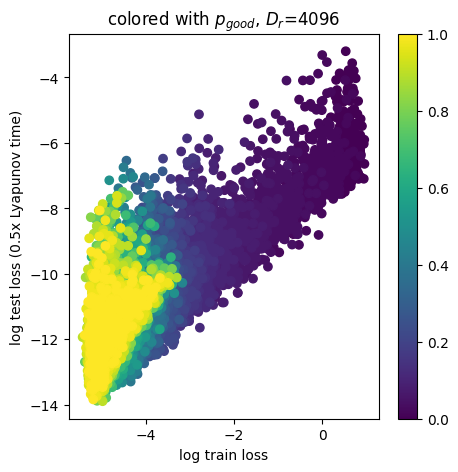

In [2]:
save_folder = '../data/L63-Strategy-varying-featuresize/'
D_r = 4096
bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
data = bsa.get_data()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
penalty = bsa.beta * (data['||W||'] * bsa.D_r)**2
im = ax.scatter(np.log(data['train_loss'] - penalty), np.log(data['test_loss_half_single'] - penalty), c=data['good_rows_W_in'])
ax.set_xlabel('log train loss')
ax.set_ylabel('log test loss (0.5x Lyapunov time)')
ax.set_title(r'colored with $p_{good}$, $D_r$='+f'{D_r}')
fig.colorbar(im, ax=ax)
plt.savefig(f'../data/plots/train_loss_vs_test_loss_single_D_r_{D_r}.png')

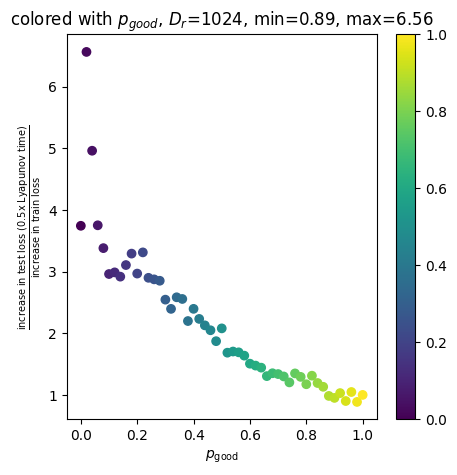

In [63]:
save_folder = '../data/L63-Strategy-varying-featuresize/'
D_r = 1024
bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
data = bsa.get_data()
percents = 50
dx = 100./percents
p = np.arange(0., 100. + dx, dx) / 100.
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
penalty = bsa.beta * (bsa.get_line('||W||')[0] * bsa.D_r)**2 * 1.
train_loss = bsa.get_line('train_loss')[0] - penalty
test_loss = bsa.get_line('test_loss_half_single')[0] - penalty
y = (test_loss/test_loss[-1]) / (train_loss/train_loss[-1])
im = ax.scatter(p, y, c=p)
ax.set_xlabel(r'$p_{\rm good}$')
ax.set_ylabel(r'$\frac{\text{increase in test loss (0.5x Lyapunov time)}}{\text{increase in train loss}}$')
ax.set_title(r'colored with $p_{good}$, $D_r$='+f'{D_r}, min={np.min(y):.2f}, max={np.max(y):.2f}')
fig.colorbar(im, ax=ax)
plt.savefig(f'../data/plots/train_loss_vs_test_loss_single_ratio_D_r_{D_r}.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


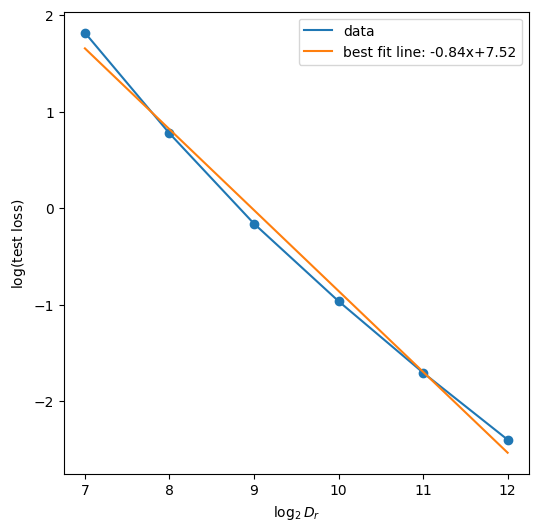

In [43]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

all_D_r = [2**n for n in [4, 5, 6, 7, 8, 9, 10, 11, 12]][3:]
err_at_idx_test = []
mean_err_test = []
err_at_idx_train = []
mean_err_train = []
err_at_idx_test_beta = []
mean_err_test_beta = []
err_at_idx_train_beta = []
mean_err_train_beta = []

W_at_idx = []
mean_W = []

index = -1
midx = 0
save_folder = '../data/L63-Strategy-varying-featuresize/'

for i, D_r in enumerate(all_D_r):
    bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
    mse = bsa.get_line('test_loss_two_single')[0] #- bsa.beta * (bsa.get_line('||W||')[0] * bsa.D_r)**2
    # ax.plot(bsa.percents, np.log2(mse), label=fr'$D_r=${D_r}')
    # ax.scatter(np.log2(D_r), np.log(mse[index]), s=5)
    err_at_idx_test.append(mse[index])
    mean_err_test.append(mse[midx:].mean())


    

ax.set_xlabel(r'$\log_2{D_r}$')
ax.set_ylabel(r'$\log({\rm test}$ ${\rm loss})$')
ax.legend()

y = np.log(err_at_idx_test)
x = np.log2(all_D_r)
lr = stats.linregress(x, y)
a, b = lr.slope, lr.intercept
ax.plot(x, y, label=r'data')
ax.scatter(x, y)
ax.plot(x, a*x+b, label=fr'best fit line: {a:.2f}x+{b:.2f}')
ax.legend()


plt.savefig('../data/plots/test_loss_vs_D_r_2.png')

**Linear rows to check overfitting**

In [142]:
D, D_r = 3, 2048
p = 12.5
G = int(D_r * p / 100.)
L = int((D_r - G)*1)
E = D_r - (G + L)
if G == D_r:
    name = 'good'
elif E == 0:
    name = 'linear'
else:
    name = 'extreme'
save_folder = f'../data/overfit/{name}_D_r_{D_r}_p_good_{p}'
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
L0, L1 = 0.4, 3.5
percents = 50
n_repeats = 500
n_models = percents * n_repeats
row_selection = 'good_50_50'
train_option = 'random_20000'
repo = '..'
L63_data_folder = '{}/data/L63-trajectories'.format(repo)
train = np.load('{}/train.npy'.format(L63_data_folder))
test = np.load('{}/test.npy'.format(L63_data_folder))[:, :1000, :]
limits_W_in, limits_W = [-0.1, 0.1], [-.5, .5]

batch = sr1.BatchStrategy_SMLR(save_folder, D, D_r, n_repeats, beta, error_threshold, train, test, dt, Lyapunov_time, L0, L1, percents,\
                          row_selection, train_option, limits_W_in, limits_W)
batch.run_single_partition([G, L, E], save_data=True)
bsa = sr1.BatchStrategyAnalyzer_SMLR(batch.save_folder)
bsa.compute_train_loss(train)
bsa.compute_test_loss_single(test)

Generating parameters for 0.12% good rows ...
Time taken by sample_parallel is 5.7693 seconds
Running experiments ...
Documenting results ...
Time taken by run_single_partition is 313.9978 seconds
Computing loss for percent id: 0 ...
Time taken for batch of training loss computations = 110.71s
Time taken by compute_train_loss is 110.7201 seconds
Computing loss for percent id: 0 ...
500
Time taken for batch of testing loss computations = 2.78s
Time taken by compute_test_loss_single is 2.7931 seconds


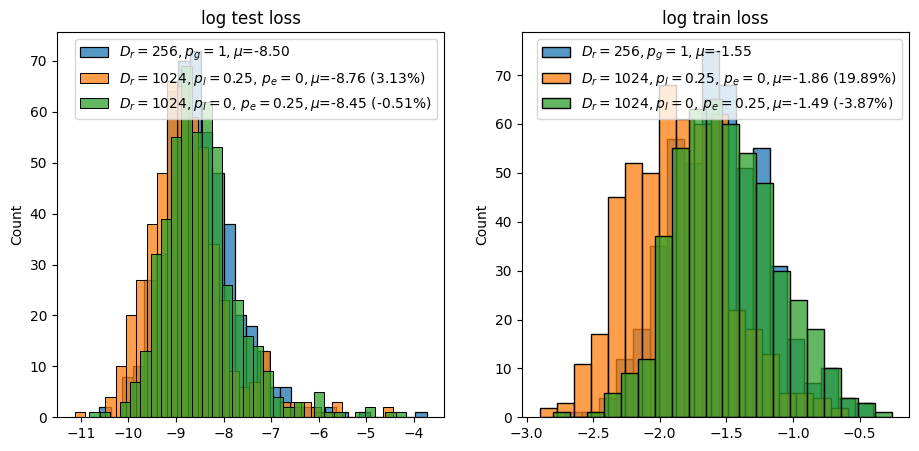

In [148]:
def get_folder(D_r=300, row='G', p=50):
    if row == 'G':
        name = 'good'
    elif row == 'L':
        name = 'linear'
    else:
        name = 'extreme'
    return f'../data/overfit/{name}_D_r_{D_r}_p_good_{p}'
D_r_1, D_r_2 = 256, 256*4
p = 25
bsa_g = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_1, row='G', p=100))
bsa_l = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_2, row='L', p=p))
bsa_e = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_2, row='E', p=p))

data_g = bsa_g.get_data()
data_l = bsa_l.get_data()
data_e = bsa_e.get_data()

penalty_g = bsa_g.beta * (data_g['||W||'] * bsa_g.D_r)**2
penalty_l = bsa_l.beta * (data_l['||W||'] * bsa_l.D_r)**2
penalty_e = bsa_e.beta * (data_e['||W||'] * bsa_e.D_r)**2

train_g, test_g = data_g['train_loss'] - penalty_g, data_g['test_loss_half_single'] - penalty_g
train_l, test_l = data_l['train_loss'] - penalty_l, data_l['test_loss_half_single'] - penalty_l
train_e, test_e = data_e['train_loss'] - penalty_e, data_e['test_loss_half_single'] - penalty_e

mtr_g, mtr_l, mtr_e = np.log(train_g).mean(), np.log(train_l).mean(), np.log(train_e).mean()
mte_g, mte_l, mte_e = np.log(test_g).mean(), np.log(test_l).mean(), np.log(test_e).mean()
mtr_l_d = (mtr_l - mtr_g) / mtr_g
mtr_e_d = (mtr_e - mtr_g) / mtr_g
mte_l_d = (mte_l - mte_g) / mte_g
mte_e_d = (mte_e - mte_g) / mte_g

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
sns.histplot(np.log(test_g), label=fr'$D_r={D_r_1}, p_g=1, \mu$={mte_g:.2f}', ax=ax)
sns.histplot(np.log(test_l), label=fr'$D_r={D_r_2}, p_l={p/100},\,p_e=0, \mu$={mte_l:.2f} ({mte_l_d*100:.2f}%)', ax=ax)
sns.histplot(np.log(test_e), label=fr'$D_r={D_r_2}, p_l=0,\,p_e={p/100}, \mu$={mte_e:.2f} ({mte_e_d*100:.2f}%)', ax=ax)
ax.set_title('log test loss')
ax.legend()

sns.histplot(np.log(train_g), label=fr'$D_r={D_r_1}, p_g=1, \mu$={mtr_g:.2f}', ax=ax1)
sns.histplot(np.log(train_l), label=fr'$D_r={D_r_2}, p_l={p/100},\,p_e=0, \mu$={mtr_l:.2f} ({mtr_l_d*100:.2f}%)', ax=ax1)
sns.histplot(np.log(train_e), label=fr'$D_r={D_r_2}, p_l=0,\,p_e={p/100}, \mu$={mtr_e:.2f} ({mtr_e_d*100:.2f}%)', ax=ax1)
ax1.set_title('log train loss')
ax1.legend()

In [ ]:
e, N = 0.67, 300
m, M = 0.4, 3.5
A = m + e
B = M - e
a = m
diff = []
for i in range(5000):
    M = np.random.uniform(low=A, high=B, size=N)
    m = np.random.uniform(low=A, high=M, size=N)
    diff.append((M-m).mean())
sns.histplot(diff)
plt.savefig('../data/sim_dist.png')

In [147]:
8.5*1.05

8.925